In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 7)

In [3]:
import seaborn as sns
from datetime import datetime, timedelta

In [18]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
from scipy import stats
import statsmodels.api as sm
from itertools import product

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
# loading the dataset
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('crypto-markets.csv', parse_dates=['date'], index_col='date',date_parser=dateparse)
df.head()

,slug,symbol,name,ranknow,open,high,low,close,volume,market,close_ratio,spread
date,,,,,,,,,,,,
2013-04-28,bitcoin,BTC,Bitcoin,1,135.30,135.98,132.10,134.21,0,1500520000,0.5438,3.88
2013-04-29,bitcoin,BTC,Bitcoin,1,134.44,147.49,134.00,144.54,0,1491160000,0.7813,13.49
2013-04-30,bitcoin,BTC,Bitcoin,1,144.00,146.93,134.05,139.00,0,1597780000,0.3843,12.88
2013-05-01,bitcoin,BTC,Bitcoin,1,139.00,139.89,107.72,116.99,0,1542820000,0.2882,32.17
2013-05-02,bitcoin,BTC,Bitcoin,1,116.38,125.60,92.28,105.21,0,1292190000,0.3881,33.32


In [8]:
# extracting the bitcoin data

btc = df[df['symbol']=='BTC']

# dropping some columns
btc.drop(['slug','symbol','name','ranknow','volume','market','close_ratio','spread'],axis=1,inplace=True)

In [9]:
print(len(btc))

1761


In [48]:
btc_month = btc.resample('M').mean()

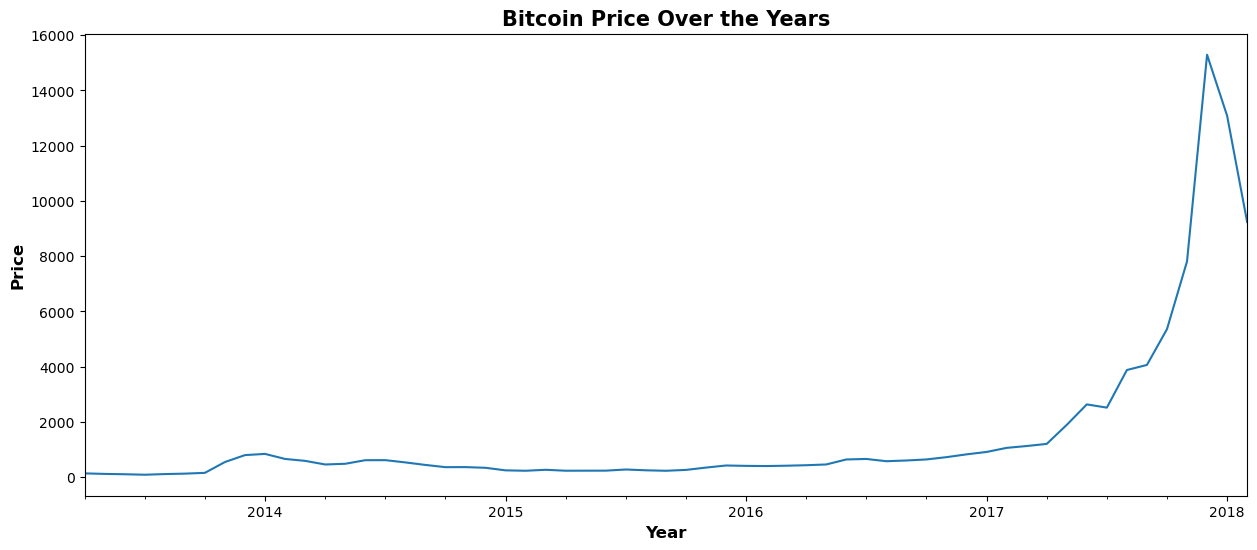

In [52]:
btc_month['close'].plot(figsize=(15, 6))
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.title('Bitcoin Price Over the Years', fontsize=15, fontweight='bold')
plt.show()

# 1. Plotting Rolling Average and Rolling Standard Deviations

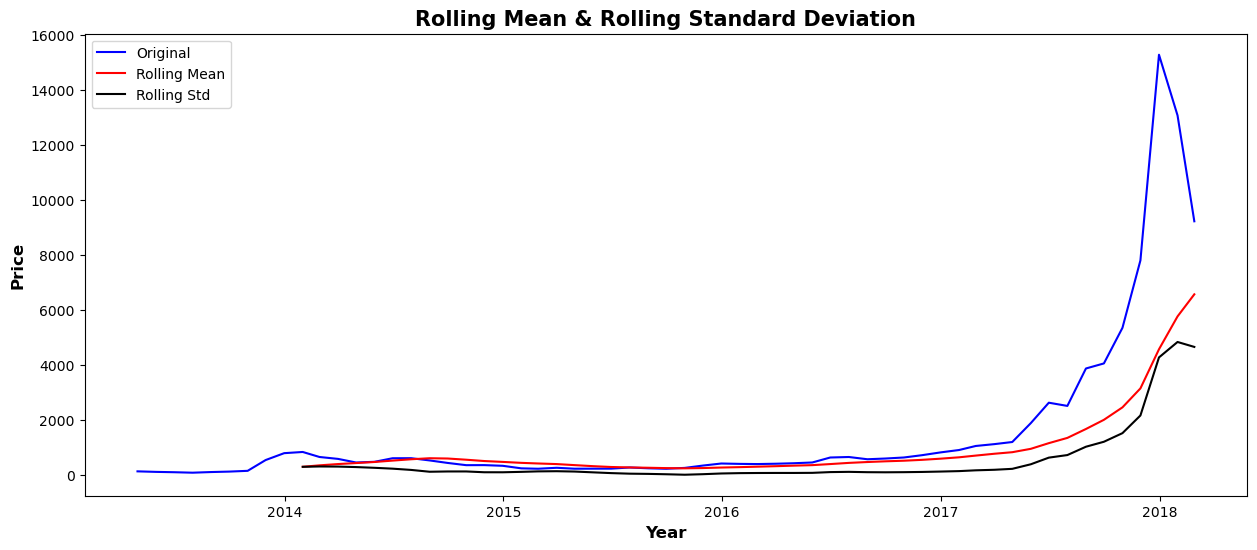

In [54]:
# plotting rolling average
window_size = 10
rolling_mean = btc_month['close'].rolling(window=window_size).mean()
rolling_std = btc_month['close'].rolling(window=window_size).std()

plt.figure(figsize=(15,6))
plt.plot(btc_month['close'], color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Rolling Standard Deviation', fontsize=15, fontweight='bold')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.show()

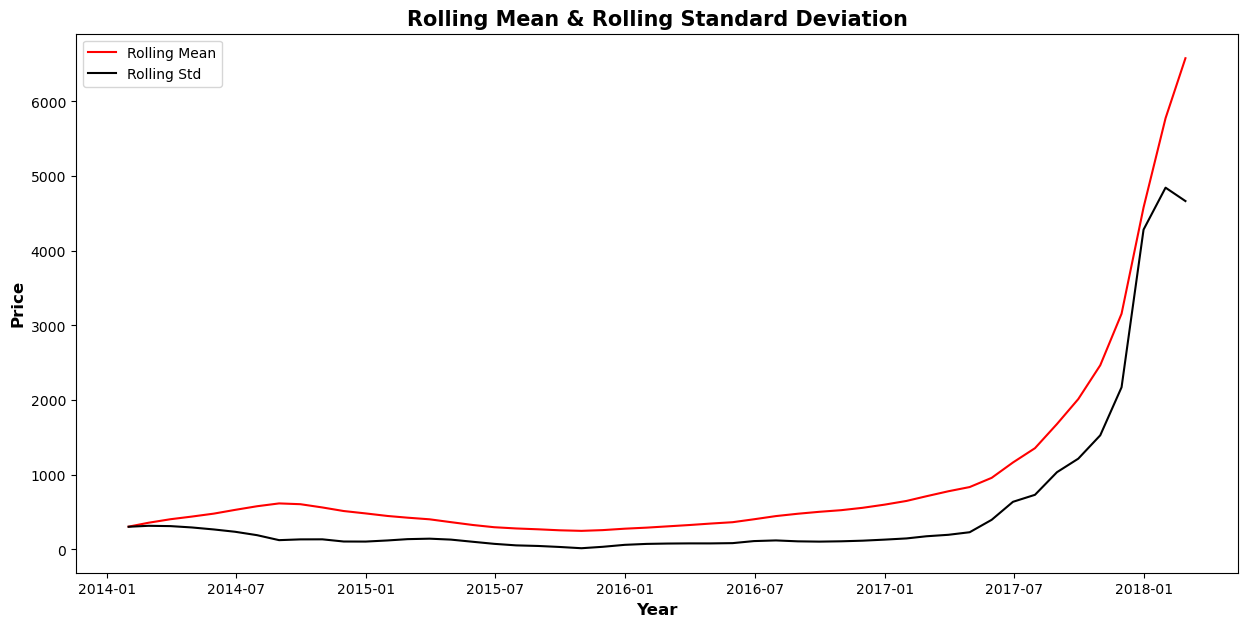

In [55]:
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Rolling Standard Deviation', fontsize=15, fontweight='bold')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.show()

# Checking If the Rolling Average and Rolling Standard Deviation are Stationary

In [63]:
print('ADF p-value for Rolling Mean: %f' % adfuller(rolling_mean.dropna())[1])
print('ADF p-value for Rolling Std: %f' % adfuller(rolling_std.dropna())[1])

ADF p-value for Rolling Mean: 1.000000
ADF p-value for Rolling Std: 0.996607


### Since the p-value is greater than 0.05, we fail to reject the null hypothesis. The rolling average and rolling standard deviation are not stationary.

# 2. Plotting the Autocorrelation

<Figure size 1500x600 with 0 Axes>

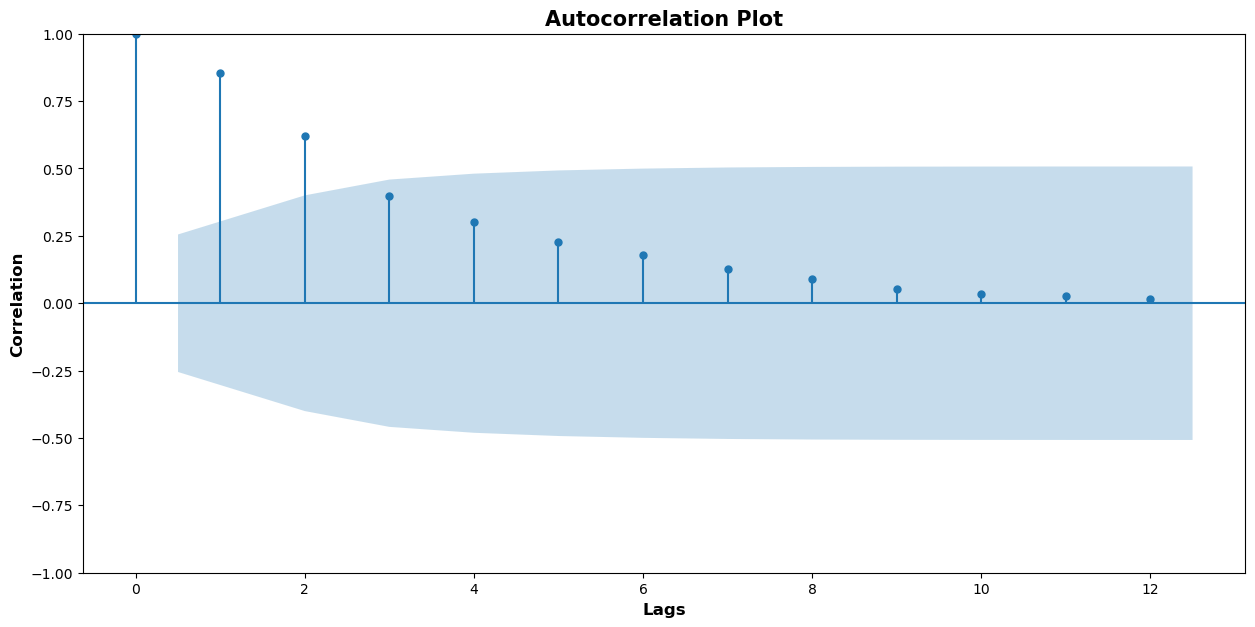

In [57]:
# plotting the autocorrelation plot
plt.figure(figsize=(15,6))
plot_acf(btc_month['close'], lags=12)
plt.xlabel('Lags', fontsize=12, fontweight='bold')
plt.ylabel('Correlation', fontsize=12, fontweight='bold')
plt.title('Autocorrelation Plot', fontsize=15, fontweight='bold')
plt.show()

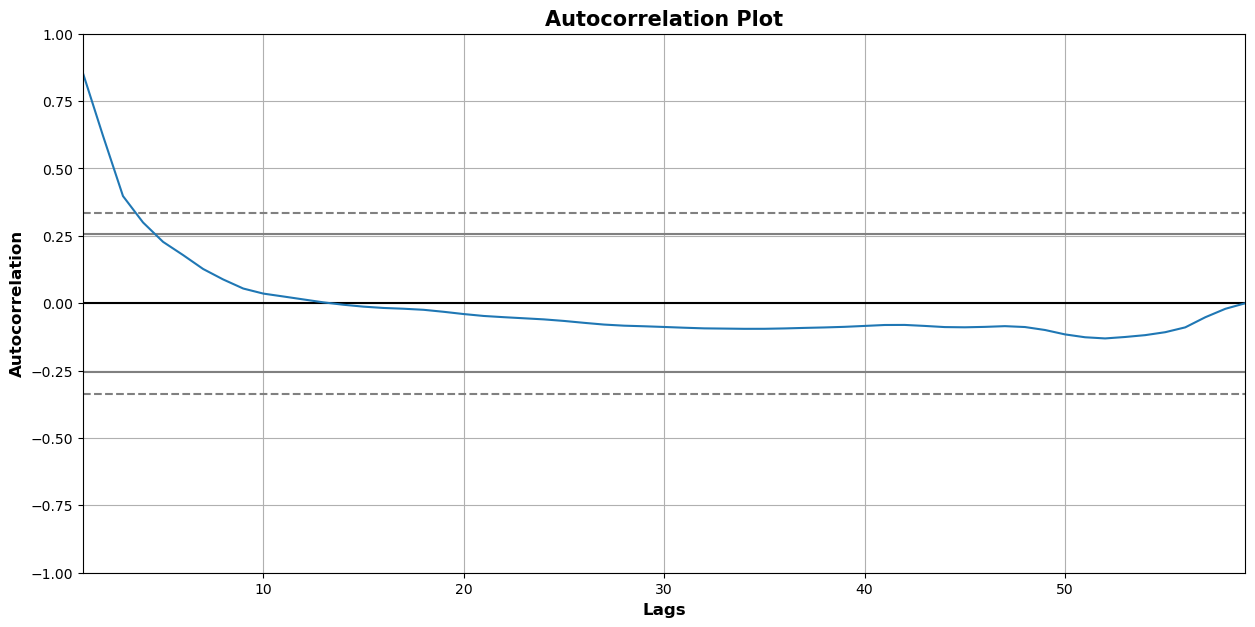

In [58]:
pd.plotting.autocorrelation_plot(btc_month['close'])
plt.xlabel('Lags', fontsize=12, fontweight='bold')
plt.ylabel('Autocorrelation', fontsize=12, fontweight='bold')
plt.title('Autocorrelation Plot', fontsize=15, fontweight='bold')
plt.show()

### From the ACF plots, we see that the rolling average and rolling standard deviation are not stationary as there are some values that are outside the confidence interval.

# 3. Removing Seasonality

### We remove seasonality by differencing the data. We take the difference between the current value and the previous value.
### Another way of doing this is by using BoxCox Transformation. This is a way of transforming non-normal dependent variables into a normal shape. This is done by raising each value in the dependent variable by a power. The power, lambda, varies from -5 to 5. In the end, the lambda that achieves the best approximation to normality is chosen. Here, we have used the BoxCox Transformation to remove seasonality.

Lambda: -0.313277


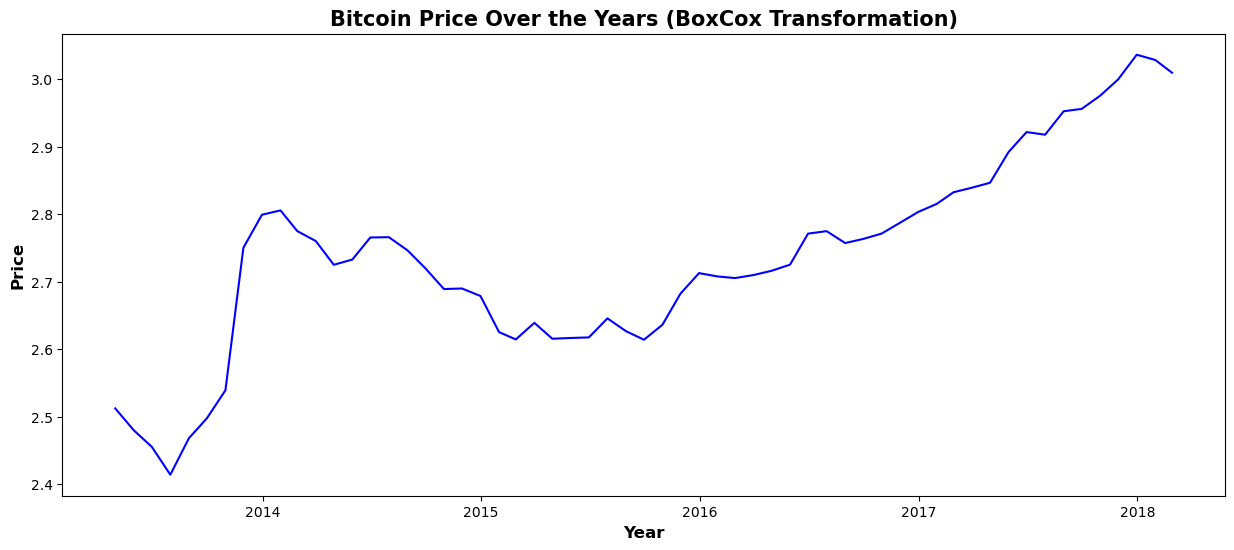

In [59]:
# removing seasonality with boxcox transformation
btc_month['close_boxcox'], lam = stats.boxcox(btc_month['close'])

print('Lambda: %f' % lam)
plt.figure(figsize=(15,6))
plt.plot(btc_month['close_boxcox'], color='blue')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.title('Bitcoin Price Over the Years (BoxCox Transformation)', fontsize=15, fontweight='bold')
plt.show()

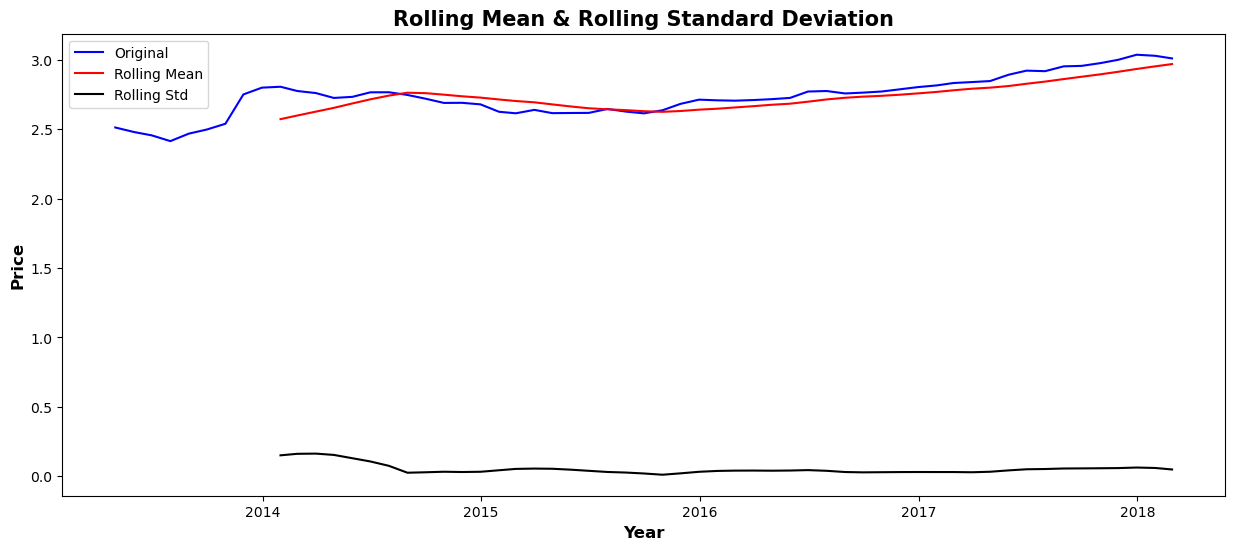

In [64]:
# plotting rolling average and rolling standard deviation
window_size = 10
rolling_mean = btc_month['close_boxcox'].rolling(window=window_size).mean()
rolling_std = btc_month['close_boxcox'].rolling(window=window_size).std()

plt.figure(figsize=(15,6))
plt.plot(btc_month['close_boxcox'], color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Rolling Standard Deviation', fontsize=15, fontweight='bold')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.show()

In [65]:
adfuller(btc_month['close_boxcox'])[1]

0.5136392090562125

### With a value of 0.5136, we see that the data is not stationary but the seasonality has been lessened compared to before. 

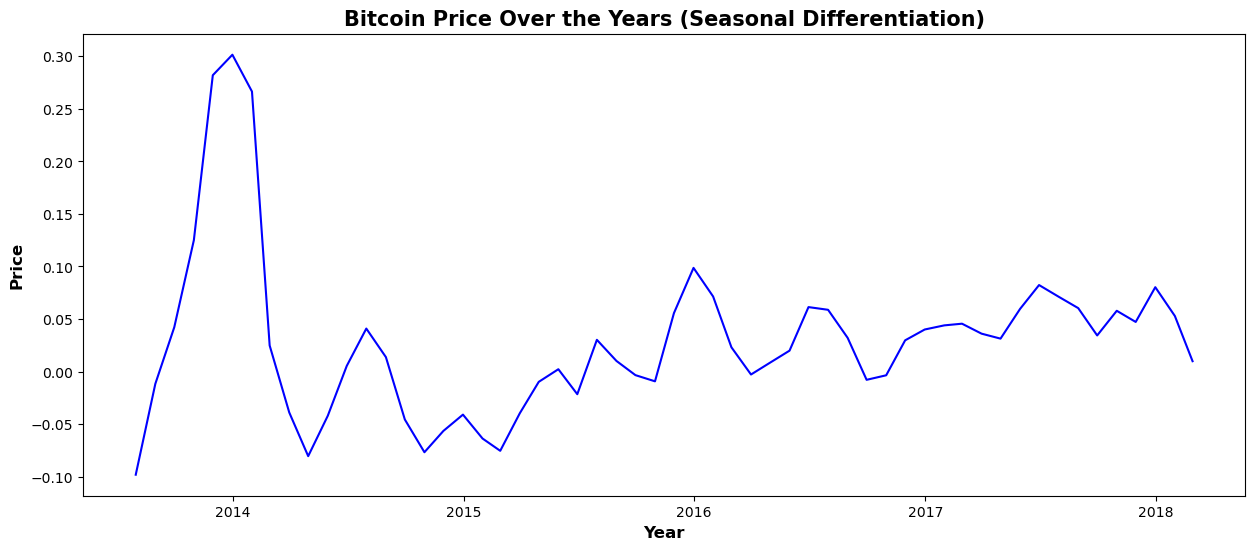

In [72]:
# using seasonal differentiation to remove seasonality
btc_month['seasonal_difference'] = btc_month['close_boxcox'] - btc_month['close_boxcox'].shift(3)

plt.figure(figsize=(15,6))
plt.plot(btc_month['seasonal_difference'], color='blue')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.title('Bitcoin Price Over the Years (Seasonal Differentiation)', fontsize=15, fontweight='bold')
plt.show()

In [74]:
adfuller(btc_month['seasonal_difference'][3:].dropna())[1]

0.017880387774106974

In [75]:
btc_month['seasonal_twelfth_difference'] = btc_month['close_boxcox'] - btc_month['close_boxcox'].shift(12)

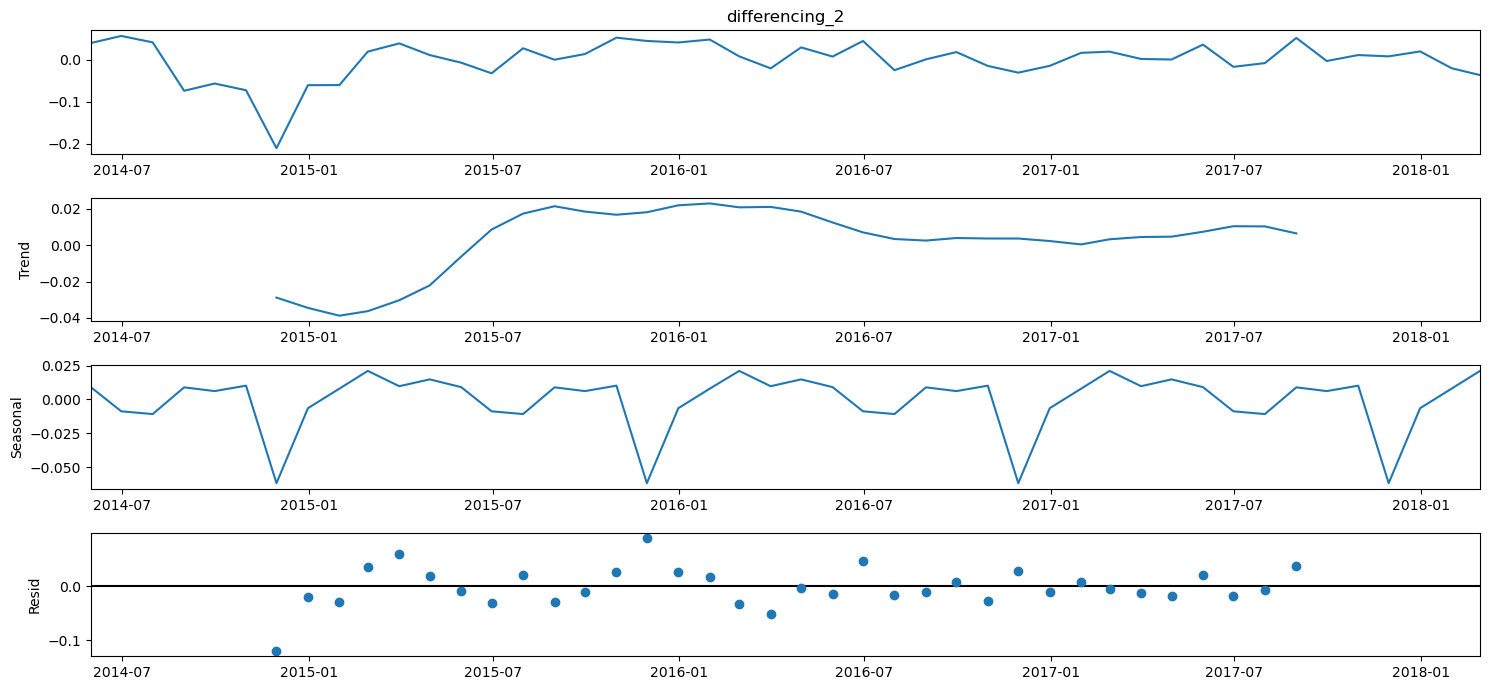

In [76]:
# differencing the data
btc_month['differencing_2'] = btc_month['seasonal_twelfth_difference'] - btc_month['seasonal_twelfth_difference'].shift(1)

seasonal_decompose(btc_month['differencing_2'][13:]).plot()
plt.show()

In [77]:
adfuller(btc_month['differencing_2'][13:].dropna())[1]

0.002295497705137167

### Now, we are ascertain that the data is stationary as the p-value (0.002285) is less than 0.05.

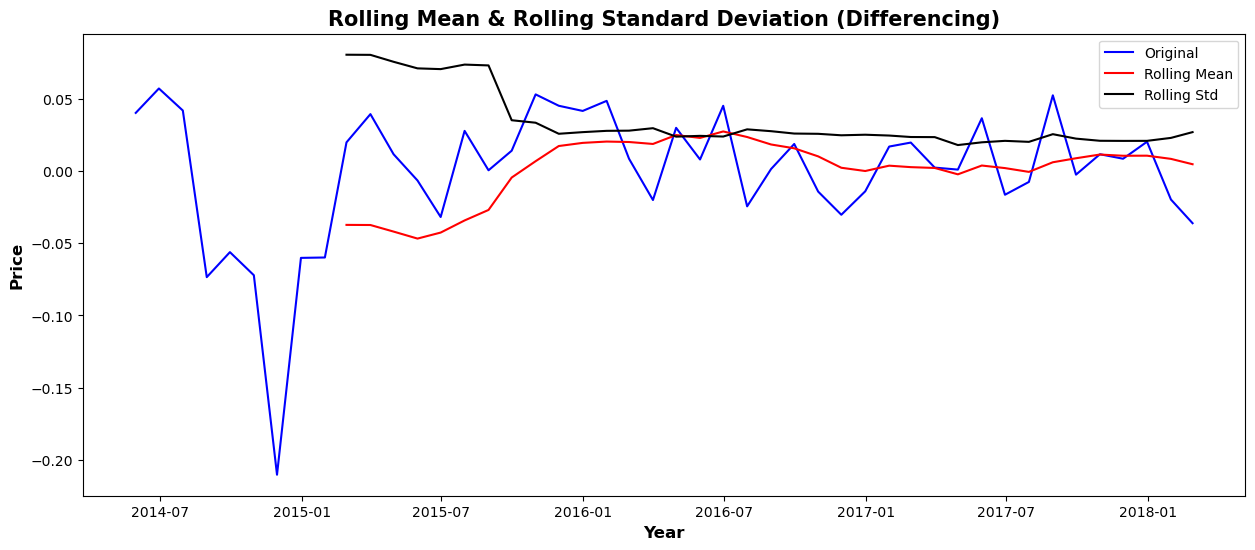

In [79]:
# plotting rolling average and rolling standard deviation
window_size = 10
rolling_mean = btc_month['differencing_2'].rolling(window=window_size).mean()
rolling_std = btc_month['differencing_2'].rolling(window=window_size).std()

plt.figure(figsize=(15,6))
plt.plot(btc_month['differencing_2'], color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Rolling Standard Deviation (Differencing)', fontsize=15, fontweight='bold')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.show()

                               SARIMAX Results                                
Dep. Variable:           close_boxcox   No. Observations:                   59
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 112.594
Date:                Thu, 11 May 2023   AIC                           -221.188
Time:                        18:39:39   BIC                           -217.067
Sample:                    04-30-2013   HQIC                          -219.583
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3737      0.151      2.471      0.013       0.077       0.670
sigma2         0.0012      0.000     11.243      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.02   Jarque-

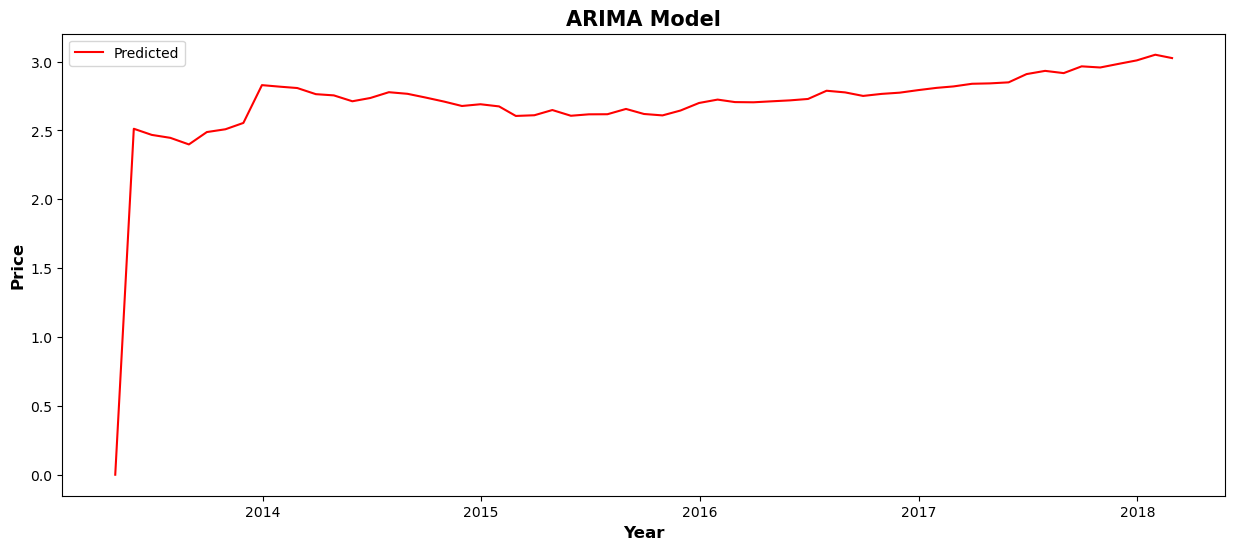

In [87]:
# fitting an arima model
model = ARIMA(btc_month['close_boxcox'], order=(1, 1, 0))
results_110 = model.fit()
print(results_110.summary())
plt.figure(figsize=(15,6))
plt.plot(results_110.fittedvalues, color='red', label='Predicted')
plt.legend(loc='best')
plt.title('ARIMA Model', fontsize=15, fontweight='bold')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.show()

                               SARIMAX Results                                
Dep. Variable:           close_boxcox   No. Observations:                   59
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 112.609
Date:                Thu, 11 May 2023   AIC                           -219.218
Time:                        18:39:44   BIC                           -213.037
Sample:                    04-30-2013   HQIC                          -216.810
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3775      0.181      2.090      0.037       0.023       0.732
ar.L2         -0.0233      0.286     -0.082      0.935      -0.583       0.536
sigma2         0.0012      0.000     10.046      0.0

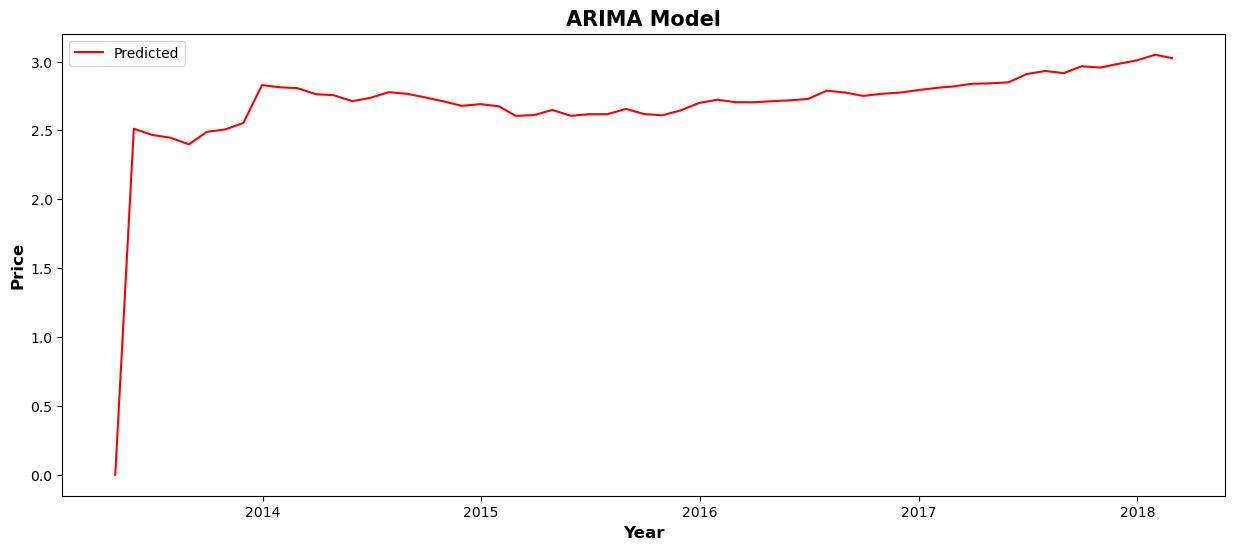

In [88]:
# fitting an arima model
model = ARIMA(btc_month['close_boxcox'], order=(2, 1, 0))
results_210 = model.fit()
print(results_210.summary())
plt.figure(figsize=(15,6))
plt.plot(results_210.fittedvalues, color='red', label='Predicted')
plt.legend(loc='best')
plt.title('ARIMA Model', fontsize=15, fontweight='bold')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.show()

                               SARIMAX Results                                
Dep. Variable:           close_boxcox   No. Observations:                   59
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 112.501
Date:                Thu, 11 May 2023   AIC                           -219.003
Time:                        18:39:48   BIC                           -212.821
Sample:                    04-30-2013   HQIC                          -216.595
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3786      0.182      2.085      0.037       0.023       0.734
ma.L2          0.0582      0.217      0.269      0.788      -0.366       0.483
sigma2         0.0012      0.000      9.741      0.0

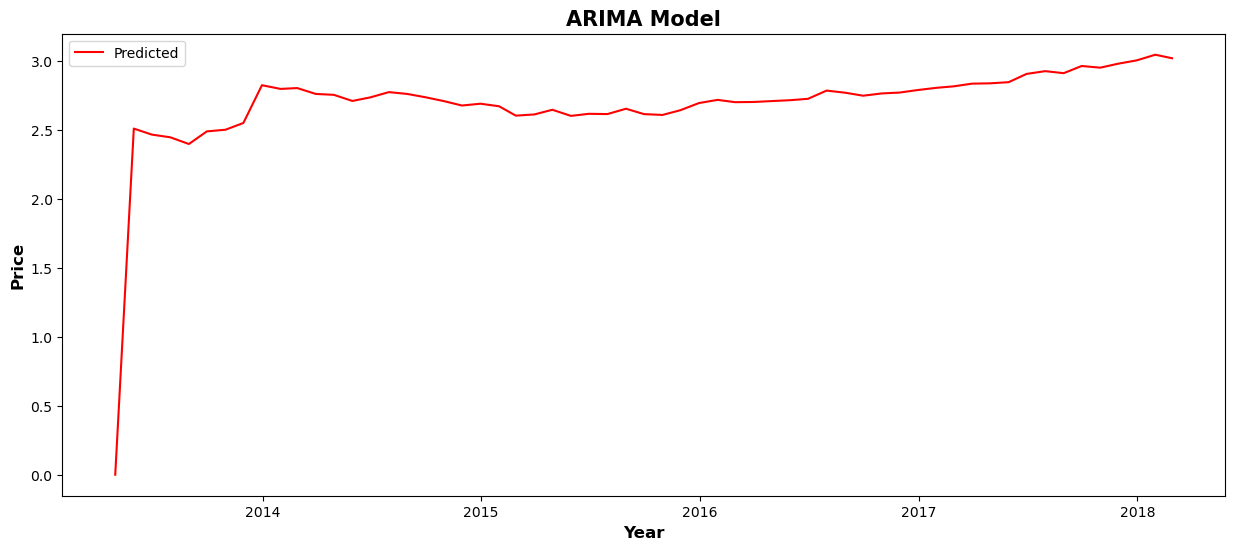

In [89]:
# fitting an arima model
model = ARIMA(btc_month['close_boxcox'], order=(0, 1, 2))
results_012 = model.fit()
print(results_012.summary())
plt.figure(figsize=(15,6))
plt.plot(results_012.fittedvalues, color='red', label='Predicted')
plt.legend(loc='best')
plt.title('ARIMA Model', fontsize=15, fontweight='bold')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.show()

                               SARIMAX Results                                
Dep. Variable:           close_boxcox   No. Observations:                   59
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 112.614
Date:                Thu, 11 May 2023   AIC                           -219.227
Time:                        18:39:51   BIC                           -213.046
Sample:                    04-30-2013   HQIC                          -216.820
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3015      0.754      0.400      0.689      -1.176       1.779
ma.L1          0.0817      0.827      0.099      0.921      -1.540       1.703
sigma2         0.0012      0.000     10.933      0.0

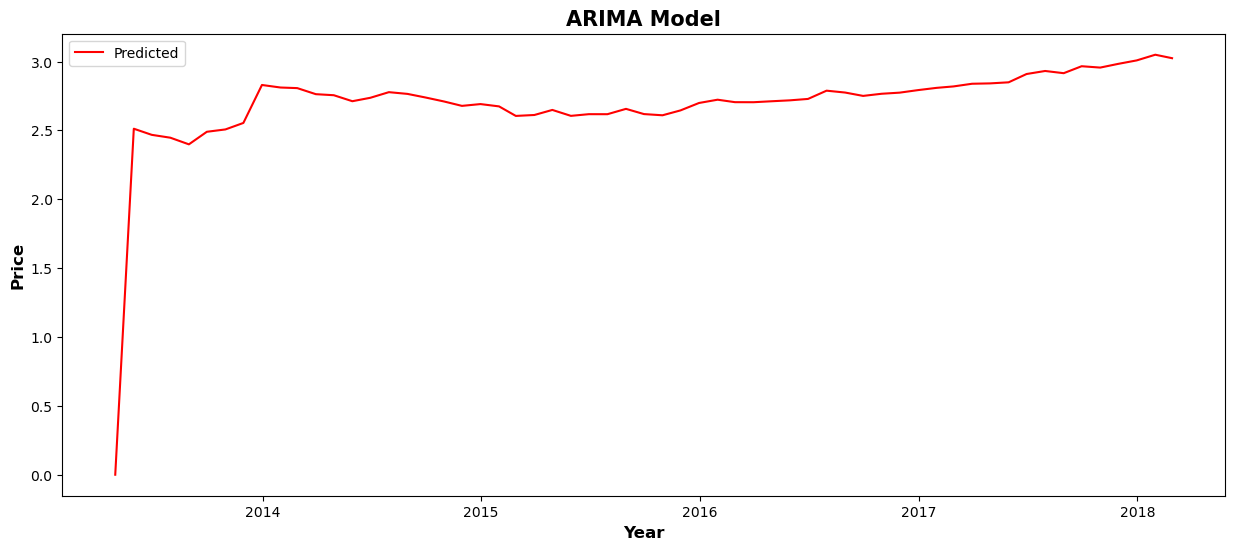

In [90]:
# fitting an arima model
model = ARIMA(btc_month['close_boxcox'], order=(1, 1, 1))
results_111 = model.fit()
print(results_111.summary())
plt.figure(figsize=(15,6))
plt.plot(results_111.fittedvalues, color='red', label='Predicted')
plt.legend(loc='best')
plt.title('ARIMA Model', fontsize=15, fontweight='bold')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.show()

In [103]:
# converting the summaries to a dataframe
summary_110 = pd.DataFrame(results_110.summary().tables[1].data[1:], columns=results_110.summary().tables[1].data[0])
summary_210 = pd.DataFrame(results_210.summary().tables[1].data[1:], columns=results_210.summary().tables[1].data[0])
summary_012 = pd.DataFrame(results_012.summary().tables[1].data[1:], columns=results_012.summary().tables[1].data[0])
summary_111 = pd.DataFrame(results_111.summary().tables[1].data[1:], columns=results_111.summary().tables[1].data[0])

In [106]:
summary_110['AIC'] = results_110.aic
summary_210['AIC'] = results_210.aic
summary_012['AIC'] = results_012.aic
summary_111['AIC'] = results_111.aic

In [107]:
# selecting the best model
summary = pd.concat([summary_110, summary_210, summary_012, summary_111])
summary = summary.reset_index(drop=True)
summary = summary.sort_values(by='AIC')
summary = summary.reset_index(drop=True)
summary.head()

,,coef,std err,z,P>|z|,[0.025,0.975],AIC
0,ar.L1,0.3737,0.151,2.471,0.013,0.077,0.670,-221.187837
1,sigma2,0.0012,0.000,11.243,0.000,0.001,0.001,-221.187837
2,ar.L1,0.3015,0.754,0.400,0.689,-1.176,1.779,-219.227474
3,ma.L1,0.0817,0.827,0.099,0.921,-1.540,1.703,-219.227474
4,sigma2,0.0012,0.000,10.933,0.000,0.001,0.001,-219.227474


### From here, we see that the model with parameters (1,1,0) is the best model as it has the lowest AIC value.

In [108]:
def invboxcox(y, lam):
   if lam == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lam*y+1)/lam))

In [109]:
# plotting the prediction prices and the original prices

# using the inverse boxcox function to get the original prices
predictions = invboxcox(results_110.fittedvalues, lam)

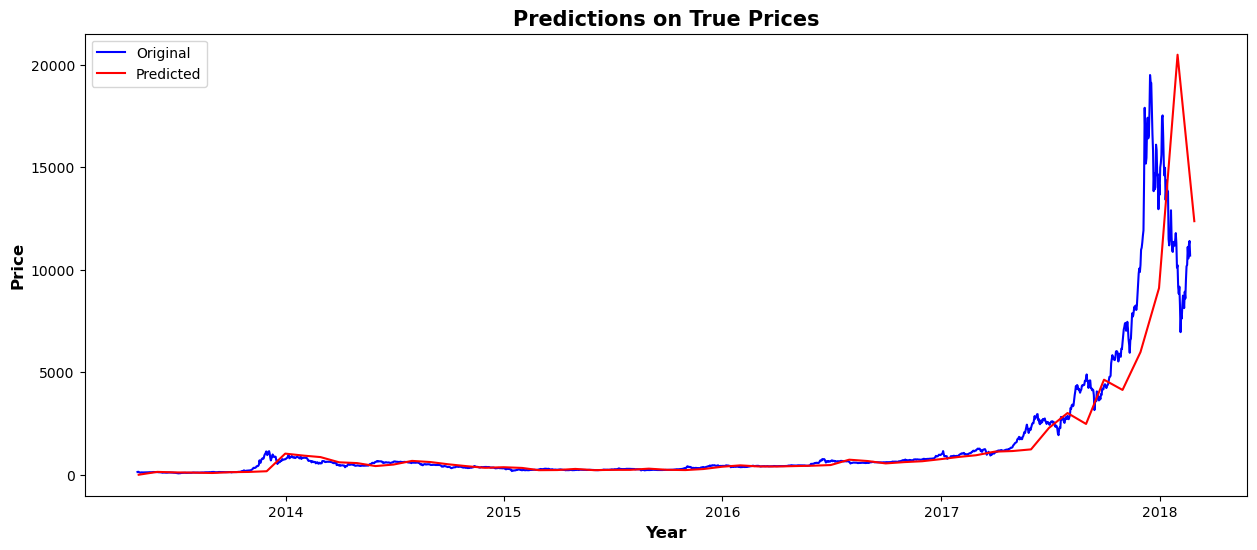

In [110]:
# plotting the original prices
plt.figure(figsize=(15,6))
plt.plot(btc['close'], color='blue', label='Original')
plt.plot(predictions, color='red', label='Predicted')
plt.legend(loc='best')
plt.title('Predictions on True Prices', fontsize=15, fontweight='bold')
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Price', fontsize=12, fontweight='bold')
plt.show()